In [5]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import astropy.coordinates as coord
import astropy.units as units
import matplotlib.pyplot as plt
import healpy as hp
import os
import random

In [6]:
nside = 64
pix_area=hp.nside2pixarea(nside, degrees = True)

# 读取数据，并计算数密度

In [7]:

# The Catalog 1 Data now lives in df. You can view they keys for examples with:col_list = ['tns_name', 'previous_name','repeater_name','ra','ra_err','ra_notes','dec','dec_err','dec_notes',
col_list = ['tns_name', 'previous_name','repeater_name','ra','ra_err','ra_notes','dec','dec_err','dec_notes',
    'gl','gb','exp_up','exp_up_err','exp_up_notes','exp_low','exp_low_err', 'exp_low_notes', 'bonsai_snr',
    'bonsai_dm','low_ft_68','up_ft_68','low_ft_95','up_ft_95','snr_fitb','dm_fitb','dm_fitb_err',
    'dm_exc_ne2001','dm_exc_ymw16','bc_width','scat_time','scat_time_err','flux','flux_err','flux_notes',
    'fluence','fluence_err','fluence_notes','sub_num','mjd_400','mjd_400_err','mjd_inf','mjd_inf_err',
    'width_fitb','width_fitb_err','sp_idx','sp_idx_err','sp_run','sp_run_err',
    'high_freq','low_freq','peak_freq', 'excluded_flag']  
# reading in the csv file
df = pd.read_csv("/home/wangsy/data/CHIME/chimefrbcat1.csv",usecols=col_list) 
#print(df.keys())

In [8]:
#select repeat FRB
C = pd.DataFrame(df)
C1 = C.duplicated(['ra'])   #查找重复项
C1 = C.drop_duplicates(['ra'])    #删除重复项
C2 = C1.sort_values(by = "dec", ascending=False)    #按照纬度排序

In [9]:
data_dm = np.array(C2.iloc[:, 24])
data_ra = np.array(C2.iloc[:, 3])
data_dec = np.array(C2.iloc[:, 6])

total = np.ones([489, 3], dtype = float)
i = 0
for i in range(0, 489):
    total[i, 0] = data_ra[i]
    total[i, 1] = data_dec[i]
    total[i, 2] = data_dm[i]

In [10]:
def S(x,y):

      #计算天区面积
      #x,y是正常赤纬的度数，且x大
          
      ipix = hp.query_strip(nside, np.radians(90-x), np.radians(90-y), nest=False, inclusive=True)  #RING pixel ordering
      n_pix = len(ipix)  
      Area = n_pix * hp.nside2pixarea(nside, degrees=True)

      return Area

In [11]:
#此函数输入赤纬bin的FRB数据，需要知道在哪个bin里，得到数密度
def number_dentisy_count(dec_data):

    N_data = len(dec_data)
    
    #判断赤纬bin
    dec_max = int(round(np.max(dec_data)/5.0)*5.0)
    dec_min = int(round(np.min(dec_data)/5.0)*5.0)

    # 赤纬bin的面积
    area = S(dec_max, dec_min)

    # 每个赤纬bin的数密度
    number_density = N_data / area

    return number_density

In [12]:
#分每个赤纬bin，读取数据，并计算数密度

lst = np.empty(20)
Number_Density = np.empty(20)
a = 95
for i in range(20):
    a = a - 5
    b = a - 5
    
    numbers_in_range = [num for num in data_dec if b <= num < a]

    lst[i] = len(numbers_in_range)
lst = lst.astype(np.int32)


start_index = 0
for i, num_rows in enumerate(lst):
    
    end_index = start_index + num_rows
    arr = total[start_index:end_index, :]
    
    dec__data = arr[:, 1]
    Number_Density[i] = number_dentisy_count(dec__data)

    start_index = end_index

    
    
print(Number_Density)



[3.08507723e-01 1.32386456e-01 4.47777718e-02 4.96449209e-02
 2.44155349e-02 3.39911170e-02 2.63268520e-02 1.99071218e-02
 1.91110979e-02 1.38050048e-02 1.33808576e-02 1.08598265e-02
 1.58243186e-02 1.48934763e-02 1.11701072e-02 6.98131701e-03
 7.44673814e-03 5.50043158e-03 1.86168454e-03 9.69627362e-05]


In [13]:
number_density_max = np.max(Number_Density) 
print(number_density_max) 

0.30850772301918816


# 实际数据

In [14]:
#start_index = 0
#Dec_Data=[]
#Ra_Data=[]
#for i, num_rows in enumerate(lst):
#    
#    end_index = start_index + num_rows
#    arr = total[start_index:end_index, :]
#    
#    Dec_Data1 = arr[:, 1]
#    Ra_Data1 = arr[:, 0]
#
#    dec__data1 = list(Dec_Data1)
#    ra__data1 = list(Ra_Data1)
#    Dec_Data.extend(dec__data1)
#    Ra_Data.extend(ra__data1)
#
#
#Dec_Data = np.array(Dec_Data)
#Ra_Data1 = np.array(Ra_Data1)
#
#dec_ra_real0001 = hp.ang2pix(nside, np.radians(90-Dec_Data), np.radians(Ra_Data))
#pix_N_real = np.bincount(dec_ra_real0001, minlength=12*nside*nside)

# 生成模拟数据

In [15]:
# 需要模拟出多少个数据--NN
def N_random(dec_max, dec_min):

    N = round(number_density_max * S(dec_max, dec_min))
    return N

In [16]:
#生成模拟数据，输入：赤纬数据，N；输出：模拟的数据信息dec，ra，两列数组
def randm(dec_data, N):
    dec_random = np.empty(N)
    ra_random = np.empty(N)

    for i in range(N):
        dec_random[i] = random.choice(dec_data)   
        ra_random[i] = random.uniform(0, 360)
    
    #dec_random = random.sample(dec_random_1, N)
    #ra_random = random.sample(ra_random_1, N)
    
    return dec_random, ra_random

In [17]:
start_index = 0
dec__max = 95
NN = np.empty(20)
Dec_Random = []   ##首次运行需要先注释掉
Ra_Random = []    ##同上
for i, num_rows in enumerate(lst):
    
    end_index = start_index + num_rows
    arr = total[start_index:end_index, :]
    
    dec__data = arr[:, 1]
    start_index = end_index
    
    
    dec__max = dec__max - 5
    dec__min = dec__max - 5

    NN = N_random(dec__max, dec__min)   ##
    #NN[i] = N_random(dec__max, dec__min)
    
    dec__random, ra__random = randm(dec__data, NN)    ##同上
    dec__random = list(dec__random)
    ra__random = list(ra__random)
    Dec_Random.extend(dec__random)
    Ra_Random.extend(ra__random)

In [18]:
len(Dec_Random)

9476

In [19]:
np.sum(NN)

663

In [20]:
NN

663

In [21]:
Dec_Random = np.array(Dec_Random)
Ra_Random = np.array(Ra_Random)

#   坐标转换：赤道 ➡️ 银道(可以不用)

In [22]:
from astropy import units as u      #用于单位转换的包
from astropy.coordinates import SkyCoord

In [23]:
c=SkyCoord(ra=Ra_Random*u.degree, dec=Dec_Random*u.degree, frame='icrs')
d=c.galactic
gl = np.array(d.l) #银经
gb = np.array(d.b)  #银纬
# d.l(银经)  d.b(银纬)

# get maps

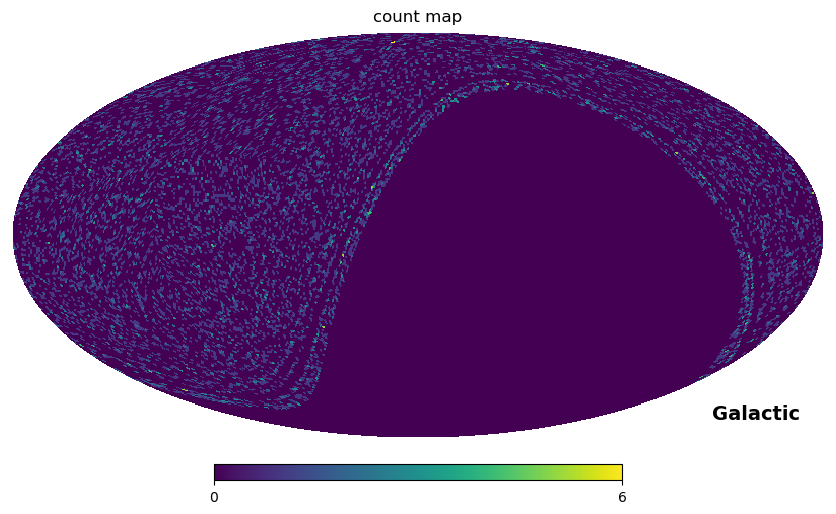

In [24]:
# count_map(1)在画图的时候指定坐标系

dec_ra_0001 = hp.ang2pix(nside, np.radians(90-Dec_Random), np.radians(Ra_Random))
pix_N = np.bincount(dec_ra_0001, minlength=12*nside*nside)
hp.mollview(pix_N, title='count map', coord="CG")

In [25]:
# count(2)先把坐标系数据转成银道坐标系

# 生成count_map
#count_map = [Dec_Random, Ra_Random]
#将FRB经纬度转化成索引(先试一组catalog) (\theat, \phi)  
#dec_ra_0001 = hp.ang2pix(nside, np.radians(90-gb), np.radians(gl))
#pix_N = np.bincount(dec_ra_0001, minlength=12*nside*nside)  #结果是：按照索引的顺序，每个像素内FRB的个数，从0开始

In [26]:
#hp.mollview(pix_N, title='count map', coord="G")

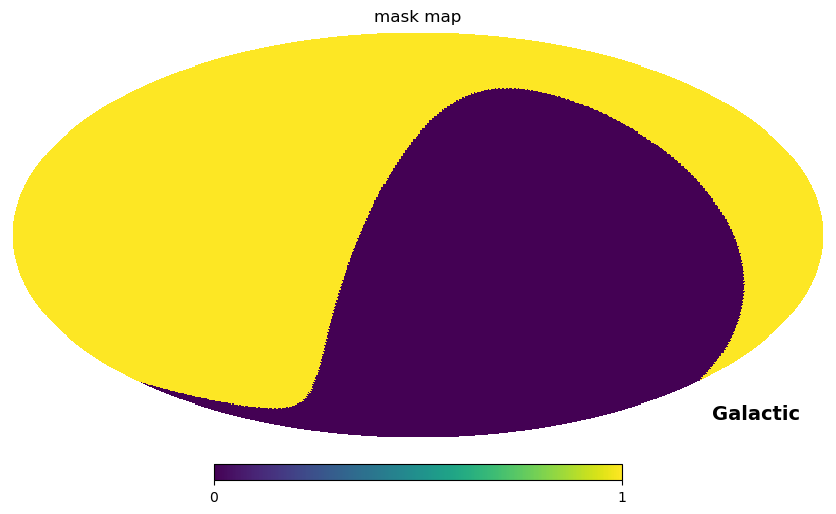

In [27]:
#生成mask
maskcut = pix_N * 0.0
ipix = hp.query_strip(nside, np.radians(0), np.radians(96.41), nest=False, inclusive=False)
len_data = len(ipix)
len_full = len(pix_N)
maskcut[:len_data] = np.ones(len_data)

hp.mollview(maskcut, title='mask map', coord="CG")

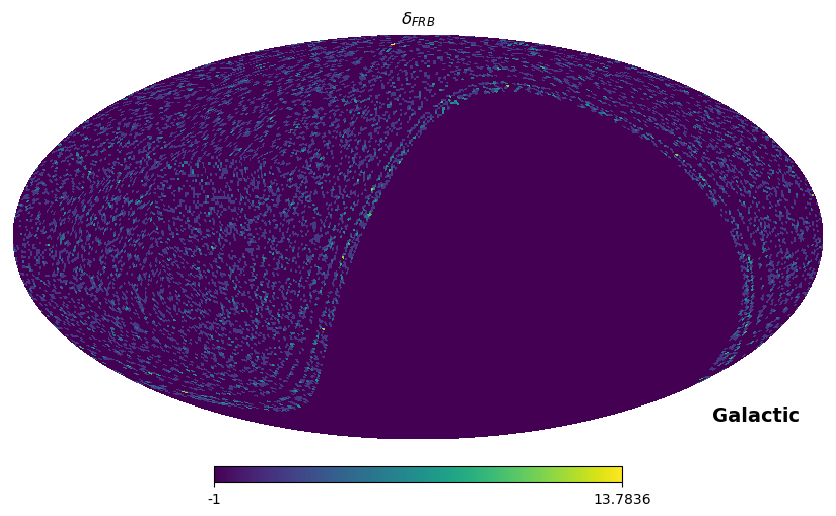

In [28]:
# 生成delta_map
n_f = number_density_max
bar_N = np.sum(maskcut * pix_N) / (np.sum(maskcut) * pix_area)

delta_FRB = np.empty(len_full)
for i in range(len_full):

    delta_FRB[i] = (pix_N[i] / bar_N) - 1

hp.mollview(delta_FRB, title='$\delta_{FRB}$', coord="CG")

In [29]:
#len(delta_FRB)

In [30]:
#plt.hist(delta_FRB, bins = 100, edgecolor="r")
#plt.xticks(np.arange(-2, 17, 1))

In [31]:
bar_N

0.40585596903339816

In [32]:
hp.fitsfunc.write_map('frb1.fits', m=pix_N, nest=False, fits_IDL=nside, coord='CG',overwrite=True)
hp.fitsfunc.write_map('mask1.fits', m=maskcut, nest=False, fits_IDL=nside, coord='CG',overwrite=True)

setting the output map dtype to [dtype('int64')]
setting the output map dtype to [dtype('float64')]
